In [24]:
import astropy.units as u
import astropy.coordinates as coord
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import gala.integrate as gi
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
import scipy.optimize as opt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec

Minimum Values

In [25]:
min5 = 7639.3429934650485
min8 = 8541.019662496845
min14 = 6873.8734879442
min17 = 6180.581801761007
min23 = 3905.9459973162066

Helper Functions

In [26]:
def calculate_orbits(dict, ics, num_steps):
    orbit = pot.integrate_orbit(ics, dt=-0.1*u.Myr, n_steps=num_steps)

    n_samples = 100
    ra_samples = np.random.normal(dict['ra'], dict['e_ra'], n_samples)
    dec_samples = np.random.normal(dict['dec'], dict['e_dec'], n_samples)
    dist_samples = np.random.normal(dict['dist'], dict['e_dist'], n_samples)
    pmra_samples = np.random.normal(dict['pmra'], dict['e_pmra'], n_samples)
    pmdec_samples = np.random.normal(dict['pmdec'], dict['e_pmdec'], n_samples)
    rv_samples = np.random.normal(dict['rv'], dict['e_rv'], n_samples)

    ics_list = []
    for ra, dec, dist, pmra, pmdec, rv in zip(ra_samples, dec_samples, dist_samples, pmra_samples, pmdec_samples, rv_samples):
        sc = coord.SkyCoord(ra=ra * u.degree,
                    dec=dec * u.degree,
                    distance=dist * u.kpc,
                    pm_ra_cosdec=pmra * (u.mas / u.yr),
                    pm_dec=pmdec * (u.mas / u.yr),
                    radial_velocity=rv * (u.km / u.s),
                    frame="icrs")
        gc = sc.transform_to(coord.Galactocentric)
        ics = gd.PhaseSpacePosition(pos=gc.cartesian.xyz, vel=gc.velocity.d_xyz)
        ics_list.append(ics)

    orbits = []
    orbits.append(orbit)
    for ics in ics_list:
        orbit = pot.integrate_orbit(ics, dt=-0.1*u.Myr, n_steps=num_steps)
        orbits.append(orbit)

    return orbits

First, define a gravitational potential.

In [27]:
pot = gp.MilkyWayPotential()

Leo I

In [28]:
dwarf_dict = {
    'ra': 152.117175, #degree
    'e_ra': 0.0001, #degree
    'dec': 12.3065, #degree
    'e_dec': 0.0001, #degree
    'dist': 254.0, #kpc
    'e_dist': 15.5, #kpc
    'pmra': -0.007, #mas/yr
    'e_pmra': 0.035, #mas/yr
    'pmdec': -0.119, #mas/yr not updated
    'e_pmdec': 0.026, #mas/yr not updated
    'rv': 282.9, #km/s
    'e_rv': 0.5, #km/s
    }
dwarf = coord.SkyCoord(
    ra=dwarf_dict['ra'] * u.degree,
    dec=dwarf_dict['dec'] * u.degree,
    distance=dwarf_dict['dist'] * u.kpc,
    pm_ra_cosdec=dwarf_dict['pmra'] * (u.mas / u.yr),
    pm_dec=dwarf_dict['pmdec'] * (u.mas / u.yr),
    radial_velocity=dwarf_dict['rv'] * (u.km / u.s),
    frame="icrs"
)
dwarf_GC = dwarf.transform_to(coord.Galactocentric)
dwarf_ics = gd.PhaseSpacePosition(pos=dwarf_GC.cartesian.xyz, vel=dwarf_GC.velocity.d_xyz)

        Use name instead. [gala.dynamics.core]


Stars

In [29]:
dict5 = {
    'ra': 139.4978105603, #degree
    'e_ra': 0.0001, #degree
    'dec': 67.3773227272, #degree
    'e_dec': 0.0001, #degree
    'dist': 44.20, #kpc
    'e_dist': 5.09, #kpc
    'pmra': 0.00, #mas/yr
    'e_pmra': 0.08, #mas/yr
    'pmdec': -0.99, #mas/yr
    'e_pmdec': 0.11, #mas/yr
    'rv': 545.50, #km/s
    'e_rv': 4.30, #km/s
    }
hvs5 = coord.SkyCoord(
    ra=dict5['ra'] * u.degree,
    dec=dict5['dec'] * u.degree,
    distance=dict5['dist'] * u.kpc,
    pm_ra_cosdec=dict5['pmra'] * (u.mas / u.yr),
    pm_dec=dict5['pmdec'] * (u.mas / u.yr),
    radial_velocity=dict5['rv'] * (u.km / u.s),
    frame="icrs"
)
hvs5_GC = hvs5.transform_to(coord.Galactocentric)
hvs5_ics = gd.PhaseSpacePosition(pos=hvs5_GC.cartesian.xyz, vel=hvs5_GC.velocity.d_xyz)

dict8 = {
    'ra': 145.5584849227, #degree
    'e_ra': 0.0001, #degree
    'dec': 20.0561234065, #degree
    'e_dec': 0.0001, #degree
    'dist': 53.19, #kpc
    'e_dist': 9.80, #kpc
    'pmra': -0.88, #mas/yr
    'e_pmra': 0.16, #mas/yr
    'pmdec': -0.28, #mas/yr
    'e_pmdec': 0.14, #mas/yr
    'rv': 499.30, #km/s
    'e_rv': 2.90, #km/s
    }
hvs8 = coord.SkyCoord(
    ra=dict8['ra'] * u.degree,
    dec=dict8['dec'] * u.degree,
    distance=dict8['dist'] * u.kpc,
    pm_ra_cosdec=dict8['pmra'] * (u.mas / u.yr),
    pm_dec=dict8['pmdec'] * (u.mas / u.yr),
    radial_velocity=dict8['rv'] * (u.km / u.s),
    frame="icrs"
)
hvs8_GC = hvs8.transform_to(coord.Galactocentric)
hvs8_ics = gd.PhaseSpacePosition(pos=hvs8_GC.cartesian.xyz, vel=hvs8_GC.velocity.d_xyz)

dict14 = {
    'ra': 161.0072805184, #degree
    'e_ra': 0.0001, #degree
    'dec': 6.1941762509, #degree
    'e_dec': 0.0001, #degree
    'dist': 102.66, #kpc
    'e_dist': 16.55, #kpc
    'pmra': -2.17, #mas/yr
    'e_pmra': 1.38, #mas/yr
    'pmdec': 2.28, #mas/yr
    'e_pmdec': 1.68, #mas/yr
    'rv': 537.30, #km/s
    'e_rv': 7.20, #km/s
    }
hvs14 = coord.SkyCoord(
    ra=dict14['ra'] * u.degree,
    dec=dict14['dec'] * u.degree,
    distance=dict14['dist'] * u.kpc,
    pm_ra_cosdec=dict14['pmra'] * (u.mas / u.yr),
    pm_dec=dict14['pmdec'] * (u.mas / u.yr),
    radial_velocity=dict14['rv'] * (u.km / u.s),
    frame="icrs"
)
hvs14_GC = hvs14.transform_to(coord.Galactocentric)
hvs14_ics = gd.PhaseSpacePosition(pos=hvs14_GC.cartesian.xyz, vel=hvs14_GC.velocity.d_xyz)

dict17 = {
    'ra': 250.4849449351, #degree
    'e_ra': 0.0001, #degree
    'dec': 47.3961264077, #degree
    'e_dec': 0.0001, #degree
    'dist': 49.82, #kpc
    'e_dist': 3.90, #kpc
    'pmra': -1.13, #mas/yr
    'e_pmra': 0.09, #mas/yr
    'pmdec': -0.93, #mas/yr
    'e_pmdec': 0.10, #mas/yr
    'rv': 250.20, #km/s
    'e_rv': 2.90, #km/s
    }
hvs17 = coord.SkyCoord(
    ra=dict17['ra'] * u.degree,
    dec=dict17['dec'] * u.degree,
    distance=dict17['dist'] * u.kpc,
    pm_ra_cosdec=dict17['pmra'] * (u.mas / u.yr),
    pm_dec=dict17['pmdec'] * (u.mas / u.yr),
    radial_velocity=dict17['rv'] * (u.km / u.s),
    frame="icrs"
)
hvs17_GC = hvs17.transform_to(coord.Galactocentric)
hvs17_ics = gd.PhaseSpacePosition(pos=hvs17_GC.cartesian.xyz, vel=hvs17_GC.velocity.d_xyz)

dict23 = {
    'ra': 329.1209186025, #degree
    'e_ra': 0.0001, #degree
    'dec': 0.9122807743, #degree
    'e_dec': 0.0001, #degree
    'dist': 114.87, #kpc
    'e_dist': 20.10, #kpc
    'pmra': -1.21, #mas/yr
    'e_pmra': 1.29, #mas/yr
    'pmdec': -2.46, #mas/yr
    'e_pmdec': 1.50, #mas/yr
    'rv': 259.30, #km/s
    'e_rv': 9.80, #km/s
    }
hvs23 = coord.SkyCoord(
    ra=dict23['ra'] * u.degree,
    dec=dict23['dec'] * u.degree,
    distance=dict23['dist'] * u.kpc,
    pm_ra_cosdec=dict23['pmra'] * (u.mas / u.yr),
    pm_dec=dict23['pmdec'] * (u.mas / u.yr),
    radial_velocity=dict23['rv'] * (u.km / u.s),
    frame="icrs"
)
hvs23_GC = hvs23.transform_to(coord.Galactocentric)
hvs23_ics = gd.PhaseSpacePosition(pos=hvs23_GC.cartesian.xyz, vel=hvs23_GC.velocity.d_xyz)

Plot HVS 5

/var/folders/6r/r2sgx64n6zn9w5rn7t027xx00000gn/T/ipykernel_76991/1188845916.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


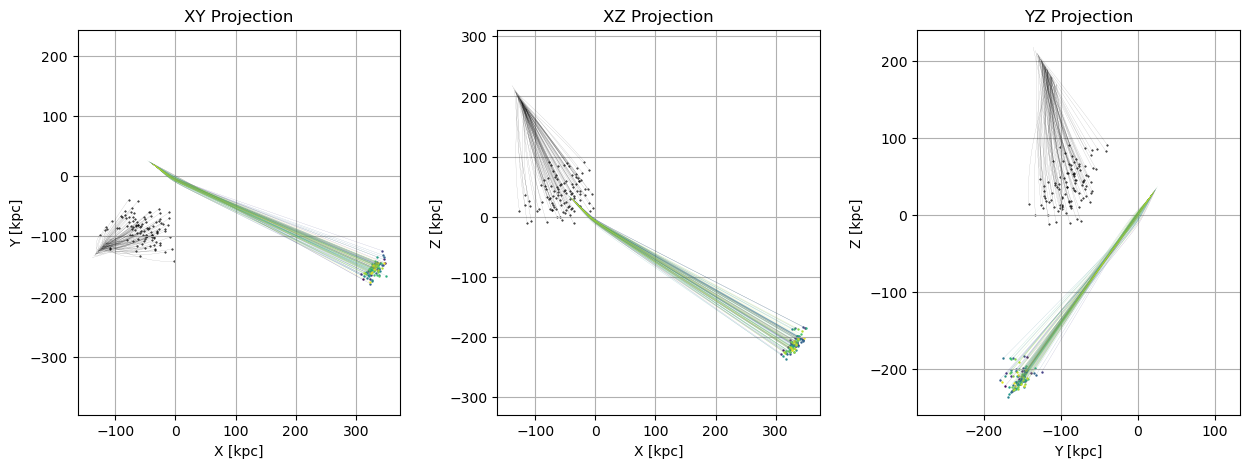

In [30]:
orbits = calculate_orbits(dict5, hvs5_ics, min5)
dwarf_orbits = calculate_orbits(dwarf_dict, dwarf_ics, min5)

n_orbits = len(orbits)
colors = cm.viridis(np.linspace(0, 1, n_orbits))

fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3, wspace=0.3)

# XY
ax_xy = fig.add_subplot(gs[0, 0])
for i, orbit in enumerate(orbits):
    pos = orbit.pos.xyz.value
    ax_xy.plot(pos[0], pos[1], color=colors[i], lw=0.1, alpha=0.7)
    ax_xy.scatter(pos[0, -1], pos[1, -1], color=colors[i], marker='o', s=0.5)
for orbit in dwarf_orbits:
    pos = orbit.pos.xyz.value
    plt.plot(pos[0], pos[1], color='black', lw=0.1, alpha=0.5)
    plt.scatter(pos[0, -1], pos[1, -1], color='black', marker='o', s=0.2)
ax_xy.set_xlabel('X [kpc]')
ax_xy.set_ylabel('Y [kpc]')
ax_xy.set_title('XY Projection')
ax_xy.axis('equal')
ax_xy.grid(True)

# XZ
ax_xz = fig.add_subplot(gs[0, 1])
for i, orbit in enumerate(orbits):
    pos = orbit.pos.xyz.value
    ax_xz.plot(pos[0], pos[2], color=colors[i], lw=0.1, alpha=0.7)
    ax_xz.scatter(pos[0, -1], pos[2, -1], color=colors[i], marker='o', s=0.5)
for orbit in dwarf_orbits:
    pos = orbit.pos.xyz.value
    plt.plot(pos[0], pos[2], color='black', lw=0.1, alpha=0.5)
    plt.scatter(pos[0, -1], pos[2, -1], color='black', marker='o', s=0.2)
ax_xz.set_xlabel('X [kpc]')
ax_xz.set_ylabel('Z [kpc]')
ax_xz.set_title('XZ Projection')
ax_xz.axis('equal')
ax_xz.grid(True)

# YZ
ax_yz = fig.add_subplot(gs[0, 2])
for i, orbit in enumerate(orbits):
    pos = orbit.pos.xyz.value
    ax_yz.plot(pos[1], pos[2], color=colors[i], lw=0.1, alpha=0.7)
    ax_yz.scatter(pos[1, -1], pos[2, -1], color=colors[i], marker='o', s=0.5)
for orbit in dwarf_orbits:
    pos = orbit.pos.xyz.value
    plt.plot(pos[1], pos[2], color='black', lw=0.1, alpha=0.5)
    plt.scatter(pos[1, -1], pos[2, -1], color='black', marker='o', s=0.2)
ax_yz.set_xlabel('Y [kpc]')
ax_yz.set_ylabel('Z [kpc]')
ax_yz.set_title('YZ Projection')
ax_yz.axis('equal')
ax_yz.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Plot HVS 8

/var/folders/6r/r2sgx64n6zn9w5rn7t027xx00000gn/T/ipykernel_76991/2794509440.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


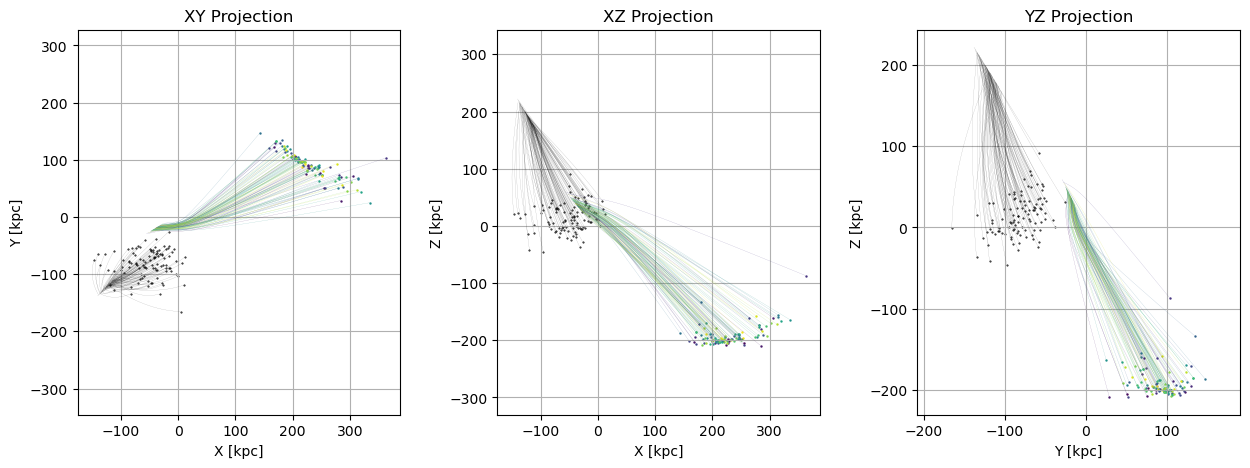

In [31]:
orbits = calculate_orbits(dict8, hvs8_ics, min8)
dwarf_orbits = calculate_orbits(dwarf_dict, dwarf_ics, min8)

n_orbits = len(orbits)
colors = cm.viridis(np.linspace(0, 1, n_orbits))

fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3, wspace=0.3)

# XY
ax_xy = fig.add_subplot(gs[0, 0])
for i, orbit in enumerate(orbits):
    pos = orbit.pos.xyz.value
    ax_xy.plot(pos[0], pos[1], color=colors[i], lw=0.1, alpha=0.7)
    ax_xy.scatter(pos[0, -1], pos[1, -1], color=colors[i], marker='o', s=0.5)
for orbit in dwarf_orbits:
    pos = orbit.pos.xyz.value
    plt.plot(pos[0], pos[1], color='black', lw=0.1, alpha=0.5)
    plt.scatter(pos[0, -1], pos[1, -1], color='black', marker='o', s=0.2)
ax_xy.set_xlabel('X [kpc]')
ax_xy.set_ylabel('Y [kpc]')
ax_xy.set_title('XY Projection')
ax_xy.axis('equal')
ax_xy.grid(True)

# XZ
ax_xz = fig.add_subplot(gs[0, 1])
for i, orbit in enumerate(orbits):
    pos = orbit.pos.xyz.value
    ax_xz.plot(pos[0], pos[2], color=colors[i], lw=0.1, alpha=0.7)
    ax_xz.scatter(pos[0, -1], pos[2, -1], color=colors[i], marker='o', s=0.5)
for orbit in dwarf_orbits:
    pos = orbit.pos.xyz.value
    plt.plot(pos[0], pos[2], color='black', lw=0.1, alpha=0.5)
    plt.scatter(pos[0, -1], pos[2, -1], color='black', marker='o', s=0.2)
ax_xz.set_xlabel('X [kpc]')
ax_xz.set_ylabel('Z [kpc]')
ax_xz.set_title('XZ Projection')
ax_xz.axis('equal')
ax_xz.grid(True)

# YZ
ax_yz = fig.add_subplot(gs[0, 2])
for i, orbit in enumerate(orbits):
    pos = orbit.pos.xyz.value
    ax_yz.plot(pos[1], pos[2], color=colors[i], lw=0.1, alpha=0.7)
    ax_yz.scatter(pos[1, -1], pos[2, -1], color=colors[i], marker='o', s=0.5)
for orbit in dwarf_orbits:
    pos = orbit.pos.xyz.value
    plt.plot(pos[1], pos[2], color='black', lw=0.1, alpha=0.5)
    plt.scatter(pos[1, -1], pos[2, -1], color='black', marker='o', s=0.2)
ax_yz.set_xlabel('Y [kpc]')
ax_yz.set_ylabel('Z [kpc]')
ax_yz.set_title('YZ Projection')
ax_yz.axis('equal')
ax_yz.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Plot HVS 14

/var/folders/6r/r2sgx64n6zn9w5rn7t027xx00000gn/T/ipykernel_76991/3983387399.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


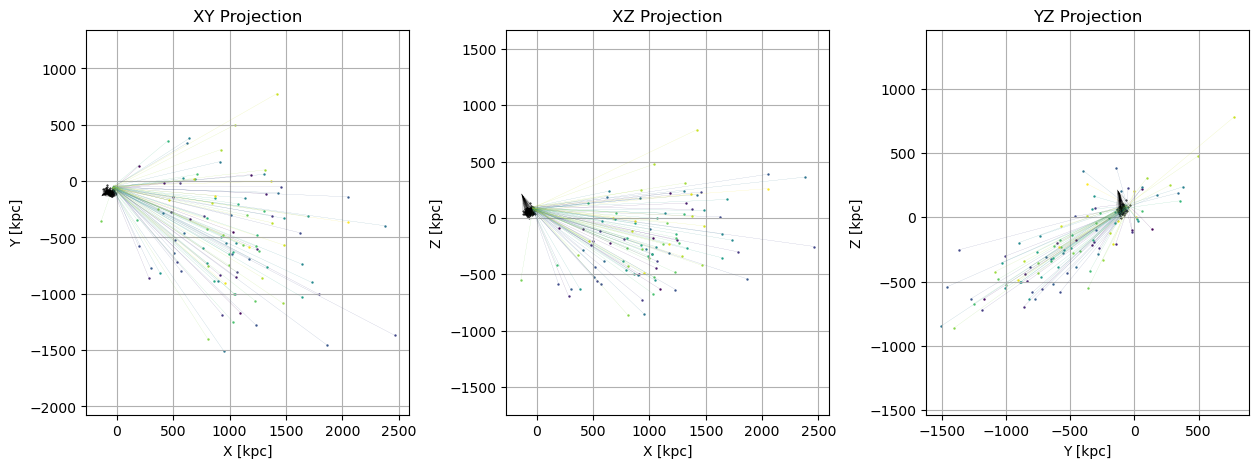

In [32]:
orbits = calculate_orbits(dict14, hvs14_ics, min14)
dwarf_orbits = calculate_orbits(dwarf_dict, dwarf_ics, min14)

n_orbits = len(orbits)
colors = cm.viridis(np.linspace(0, 1, n_orbits))

fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3, wspace=0.3)

# XY
ax_xy = fig.add_subplot(gs[0, 0])
for i, orbit in enumerate(orbits):
    pos = orbit.pos.xyz.value
    ax_xy.plot(pos[0], pos[1], color=colors[i], lw=0.1, alpha=0.7)
    ax_xy.scatter(pos[0, -1], pos[1, -1], color=colors[i], marker='o', s=0.5)
for orbit in dwarf_orbits:
    pos = orbit.pos.xyz.value
    plt.plot(pos[0], pos[1], color='black', lw=0.1, alpha=0.5)
    plt.scatter(pos[0, -1], pos[1, -1], color='black', marker='o', s=0.2)
ax_xy.set_xlabel('X [kpc]')
ax_xy.set_ylabel('Y [kpc]')
ax_xy.set_title('XY Projection')
ax_xy.axis('equal')
ax_xy.grid(True)

# XZ
ax_xz = fig.add_subplot(gs[0, 1])
for i, orbit in enumerate(orbits):
    pos = orbit.pos.xyz.value
    ax_xz.plot(pos[0], pos[2], color=colors[i], lw=0.1, alpha=0.7)
    ax_xz.scatter(pos[0, -1], pos[2, -1], color=colors[i], marker='o', s=0.5)
for orbit in dwarf_orbits:
    pos = orbit.pos.xyz.value
    plt.plot(pos[0], pos[2], color='black', lw=0.1, alpha=0.5)
    plt.scatter(pos[0, -1], pos[2, -1], color='black', marker='o', s=0.2)
ax_xz.set_xlabel('X [kpc]')
ax_xz.set_ylabel('Z [kpc]')
ax_xz.set_title('XZ Projection')
ax_xz.axis('equal')
ax_xz.grid(True)

# YZ
ax_yz = fig.add_subplot(gs[0, 2])
for i, orbit in enumerate(orbits):
    pos = orbit.pos.xyz.value
    ax_yz.plot(pos[1], pos[2], color=colors[i], lw=0.1, alpha=0.7)
    ax_yz.scatter(pos[1, -1], pos[2, -1], color=colors[i], marker='o', s=0.5)
for orbit in dwarf_orbits:
    pos = orbit.pos.xyz.value
    plt.plot(pos[1], pos[2], color='black', lw=0.1, alpha=0.5)
    plt.scatter(pos[1, -1], pos[2, -1], color='black', marker='o', s=0.2)
ax_yz.set_xlabel('Y [kpc]')
ax_yz.set_ylabel('Z [kpc]')
ax_yz.set_title('YZ Projection')
ax_yz.axis('equal')
ax_yz.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Plot HVS 17

/var/folders/6r/r2sgx64n6zn9w5rn7t027xx00000gn/T/ipykernel_76991/2761235408.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


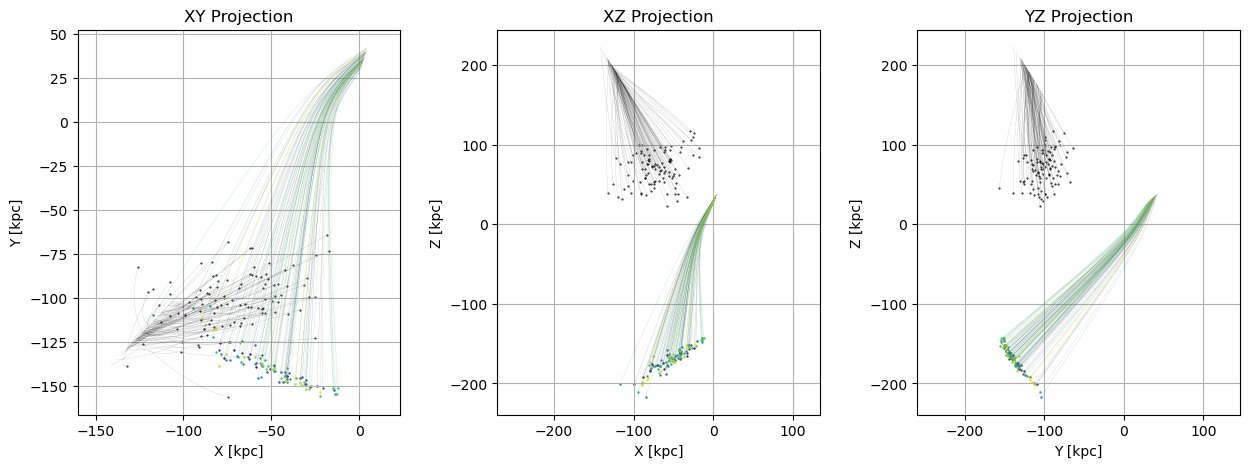

In [33]:
orbits = calculate_orbits(dict17, hvs17_ics, min17)
dwarf_orbits = calculate_orbits(dwarf_dict, dwarf_ics, min17)

n_orbits = len(orbits)
colors = cm.viridis(np.linspace(0, 1, n_orbits))

fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3, wspace=0.3)

# XY
ax_xy = fig.add_subplot(gs[0, 0])
for i, orbit in enumerate(orbits):
    pos = orbit.pos.xyz.value
    ax_xy.plot(pos[0], pos[1], color=colors[i], lw=0.1, alpha=0.7)
    ax_xy.scatter(pos[0, -1], pos[1, -1], color=colors[i], marker='o', s=0.5)
for orbit in dwarf_orbits:
    pos = orbit.pos.xyz.value
    plt.plot(pos[0], pos[1], color='black', lw=0.1, alpha=0.5)
    plt.scatter(pos[0, -1], pos[1, -1], color='black', marker='o', s=0.2)
ax_xy.set_xlabel('X [kpc]')
ax_xy.set_ylabel('Y [kpc]')
ax_xy.set_title('XY Projection')
ax_xy.axis('equal')
ax_xy.grid(True)

# XZ
ax_xz = fig.add_subplot(gs[0, 1])
for i, orbit in enumerate(orbits):
    pos = orbit.pos.xyz.value
    ax_xz.plot(pos[0], pos[2], color=colors[i], lw=0.1, alpha=0.7)
    ax_xz.scatter(pos[0, -1], pos[2, -1], color=colors[i], marker='o', s=0.5)
for orbit in dwarf_orbits:
    pos = orbit.pos.xyz.value
    plt.plot(pos[0], pos[2], color='black', lw=0.1, alpha=0.5)
    plt.scatter(pos[0, -1], pos[2, -1], color='black', marker='o', s=0.2)
ax_xz.set_xlabel('X [kpc]')
ax_xz.set_ylabel('Z [kpc]')
ax_xz.set_title('XZ Projection')
ax_xz.axis('equal')
ax_xz.grid(True)

# YZ
ax_yz = fig.add_subplot(gs[0, 2])
for i, orbit in enumerate(orbits):
    pos = orbit.pos.xyz.value
    ax_yz.plot(pos[1], pos[2], color=colors[i], lw=0.1, alpha=0.7)
    ax_yz.scatter(pos[1, -1], pos[2, -1], color=colors[i], marker='o', s=0.5)
for orbit in dwarf_orbits:
    pos = orbit.pos.xyz.value
    plt.plot(pos[1], pos[2], color='black', lw=0.1, alpha=0.5)
    plt.scatter(pos[1, -1], pos[2, -1], color='black', marker='o', s=0.2)
ax_yz.set_xlabel('Y [kpc]')
ax_yz.set_ylabel('Z [kpc]')
ax_yz.set_title('YZ Projection')
ax_yz.axis('equal')
ax_yz.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Plot HVS 23

/var/folders/6r/r2sgx64n6zn9w5rn7t027xx00000gn/T/ipykernel_76991/2649090045.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


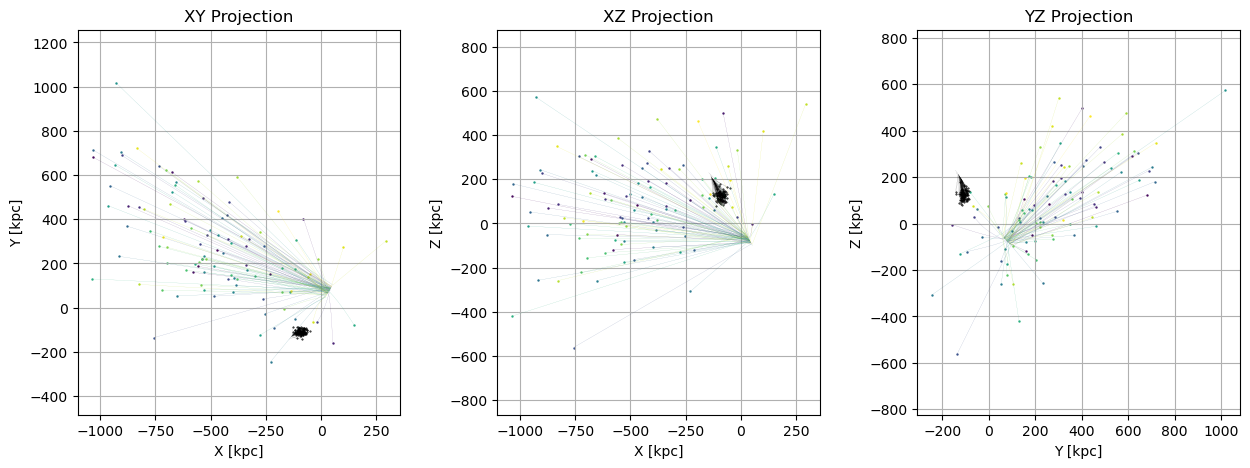

In [34]:
orbits = calculate_orbits(dict23, hvs23_ics, min23)
dwarf_orbits = calculate_orbits(dwarf_dict, dwarf_ics, min23)

n_orbits = len(orbits)
colors = cm.viridis(np.linspace(0, 1, n_orbits))

fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3, wspace=0.3)

# XY
ax_xy = fig.add_subplot(gs[0, 0])
for i, orbit in enumerate(orbits):
    pos = orbit.pos.xyz.value
    ax_xy.plot(pos[0], pos[1], color=colors[i], lw=0.1, alpha=0.7)
    ax_xy.scatter(pos[0, -1], pos[1, -1], color=colors[i], marker='o', s=0.5)
for orbit in dwarf_orbits:
    pos = orbit.pos.xyz.value
    plt.plot(pos[0], pos[1], color='black', lw=0.1, alpha=0.5)
    plt.scatter(pos[0, -1], pos[1, -1], color='black', marker='o', s=0.2)
ax_xy.set_xlabel('X [kpc]')
ax_xy.set_ylabel('Y [kpc]')
ax_xy.set_title('XY Projection')
ax_xy.axis('equal')
ax_xy.grid(True)

# XZ
ax_xz = fig.add_subplot(gs[0, 1])
for i, orbit in enumerate(orbits):
    pos = orbit.pos.xyz.value
    ax_xz.plot(pos[0], pos[2], color=colors[i], lw=0.1, alpha=0.7)
    ax_xz.scatter(pos[0, -1], pos[2, -1], color=colors[i], marker='o', s=0.5)
for orbit in dwarf_orbits:
    pos = orbit.pos.xyz.value
    plt.plot(pos[0], pos[2], color='black', lw=0.1, alpha=0.5)
    plt.scatter(pos[0, -1], pos[2, -1], color='black', marker='o', s=0.2)
ax_xz.set_xlabel('X [kpc]')
ax_xz.set_ylabel('Z [kpc]')
ax_xz.set_title('XZ Projection')
ax_xz.axis('equal')
ax_xz.grid(True)

# YZ
ax_yz = fig.add_subplot(gs[0, 2])
for i, orbit in enumerate(orbits):
    pos = orbit.pos.xyz.value
    ax_yz.plot(pos[1], pos[2], color=colors[i], lw=0.1, alpha=0.7)
    ax_yz.scatter(pos[1, -1], pos[2, -1], color=colors[i], marker='o', s=0.5)
for orbit in dwarf_orbits:
    pos = orbit.pos.xyz.value
    plt.plot(pos[1], pos[2], color='black', lw=0.1, alpha=0.5)
    plt.scatter(pos[1, -1], pos[2, -1], color='black', marker='o', s=0.2)
ax_yz.set_xlabel('Y [kpc]')
ax_yz.set_ylabel('Z [kpc]')
ax_yz.set_title('YZ Projection')
ax_yz.axis('equal')
ax_yz.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()